# Notebook 01 — Load Real Bank Prices & Basic EDA

This notebook assumes that the CSV file with **real bank
equity prices** is already uploaded to:

- `data/raw/sample_prices.csv`

The goal of this notebook is to:

1. Make sure the notebook runs from the **project root** so that paths work.
2. Load the real price data from `data/raw/sample_prices.csv`.
3. Apply light cleaning/sanitizing:
   - parse dates as index
   - clean column names
   - convert values to numeric
   - drop empty columns or bad rows
4. Report missing values per ticker.
5. Plot the price series and save the figure to `results/figures/`.

The cleaned price DataFrame will be the starting point for **Notebook 02**
(returns, rolling stats, stress index, labels).

In [1]:
# --- Cell 2: Fix working directory and make src/ importable ---

import os
import sys
from pathlib import Path

# The notebook file lives in <project_root>/notebooks,
# so the project root is the parent directory of the current one.
NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent

# Change working directory so that relative paths (like "data/raw") are
# resolved from the project root.
os.chdir(PROJECT_ROOT)

# Ensure src/ is on sys.path so that `import bank_stress...` works if needed.
SRC_DIR = PROJECT_ROOT / "src"
if str(SRC_DIR) not in sys.path:
    sys.path.insert(0, str(SRC_DIR))

print("Running from:", Path.cwd())
print("SRC_DIR:", SRC_DIR)

Running from: /files/bank_stress_detection_project_datascience_class
SRC_DIR: /files/bank_stress_detection_project_datascience_class/src


In [2]:
# --- Cell 3: Define paths and load sample_prices.csv ---

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

# Raw data folder and results folder for figures.
RAW_DIR = PROJECT_ROOT / "data" / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

RESULTS_DIR = PROJECT_ROOT / "results" / "figures"
RESULTS_DIR.mkdir(parents=True, exist_ok=True)

# Path to your uploaded real-world price data.
CSV_PATH = RAW_DIR / "sample_prices.csv"

print("Raw data path:   ", CSV_PATH.resolve())
print("Results dir path:", RESULTS_DIR.resolve())

# ------------------------------------------------------------------
# Load and sanitize the CSV
# ------------------------------------------------------------------
if not CSV_PATH.exists():
    raise FileNotFoundError(
        f"CSV not found: {CSV_PATH}\n"
        "Upload data/raw/sample_prices.csv or adjust CSV_PATH.",
    )

# Try to read with UTF-8 first, then fall back to latin-1 if needed.
try:
    prices = pd.read_csv(
        CSV_PATH,
        index_col=0,
        parse_dates=True,
        encoding="utf-8",
    )
except Exception:
    prices = pd.read_csv(
        CSV_PATH,
        index_col=0,
        parse_dates=True,
        encoding="latin-1",
    )

# Normalize index: ensure all index entries are valid datetimes.
prices.index = pd.to_datetime(prices.index, errors="coerce")

# Drop rows with invalid (NaT) dates.
if prices.index.isna().any():
    prices = prices.loc[~prices.index.isna()]

# Clean up column names: strip whitespace, remove Excel "Unnamed" columns.
prices.columns = [str(col).strip() for col in prices.columns]
prices = prices.loc[:, ~prices.columns.str.match(r"^Unnamed")]

# Convert all columns to numeric, coercing errors to NaN.
for col in prices.columns:
    prices[col] = pd.to_numeric(prices[col], errors="coerce")

# Drop columns that are entirely NaN (no usable data).
all_nan_cols = prices.columns[prices.isna().all()].tolist()
if all_nan_cols:
    print("Dropping all-NaN columns:", all_nan_cols)
    prices = prices.drop(columns=all_nan_cols)

# Sort index by date ascending.
prices = prices.sort_index()

# Basic sanity check.
if prices.empty:
    raise ValueError(
        "Loaded DataFrame is empty after parsing. "
        "Please check the format of sample_prices.csv.",
    )

print("\nLoaded price data (sanitized):")
display(prices.head())
print("\nShape (rows, columns):", prices.shape)
print("Tickers:", list(prices.columns))

Raw data path:    /files/bank_stress_detection_project_datascience_class/data/raw/sample_prices.csv
Results dir path: /files/bank_stress_detection_project_datascience_class/results/figures

Loaded price data (sanitized):


,JPM,BAC,C,WFC,GS,MS,USB,PNC,TFC,CMA,CFG
Date,,,,,,,,,,,
2000-01-03 00:00:00-05:00,23.013842,12.490806,207.768265,9.648853,61.663662,32.863632,8.710556,19.034946,9.855802,19.051611,NaN
2000-01-04 00:00:00-05:00,22.508884,11.749408,195.027679,9.171043,57.779690,30.429289,8.392846,18.442753,9.569435,18.257793,NaN
2000-01-05 00:00:00-05:00,22.369938,11.878347,202.868027,9.078558,55.073978,29.318615,8.207516,18.527353,9.688752,18.204874,NaN
2000-01-06 00:00:00-05:00,22.687529,12.893735,212.668304,9.479308,57.430576,29.881571,8.842937,19.401554,10.142168,18.734070,NaN
2000-01-07 00:00:00-05:00,23.104355,12.555271,211.688431,9.648853,57.648777,30.809662,9.187122,19.429750,10.213759,18.707626,NaN



Shape (rows, columns): (2356, 11)
Tickers: ['JPM', 'BAC', 'C', 'WFC', 'GS', 'MS', 'USB', 'PNC', 'TFC', 'CMA', 'CFG']


In [3]:
# --- Cell 4: Missing values diagnostics ---

missing_counts = prices.isna().sum()
missing_pct = (missing_counts / len(prices)) * 100.0

print("Missing values per ticker (count and percentage):")
for col in prices.columns:
    count = int(missing_counts[col])
    pct = float(missing_pct[col])
    print(f" - {col}: {count} missing ({pct:.2f}%)")

Missing values per ticker (count and percentage):
 - JPM: 0 missing (0.00%)
 - BAC: 0 missing (0.00%)
 - C: 0 missing (0.00%)
 - WFC: 0 missing (0.00%)
 - GS: 0 missing (0.00%)
 - MS: 0 missing (0.00%)
 - USB: 0 missing (0.00%)
 - PNC: 0 missing (0.00%)
 - TFC: 0 missing (0.00%)
 - CMA: 0 missing (0.00%)
 - CFG: 1397 missing (59.30%)


Saved figure to: /files/bank_stress_detection_project_datascience_class/results/figures/prices_overview.png


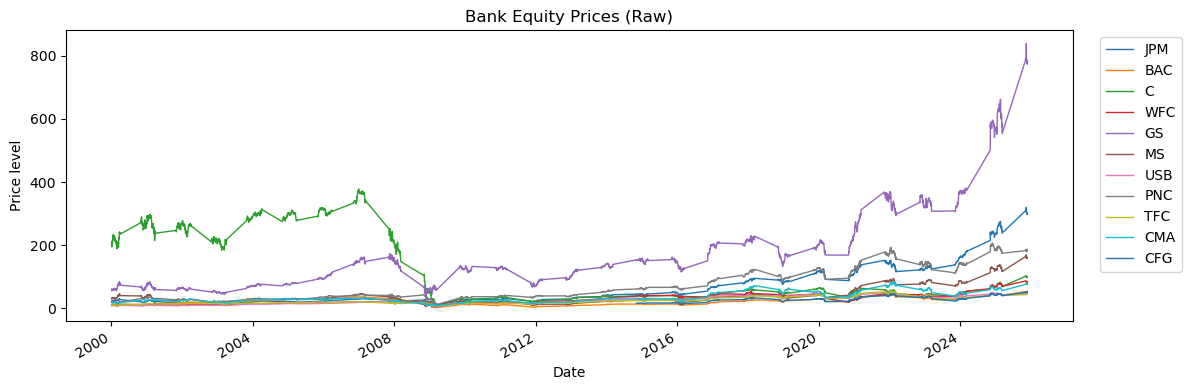

In [4]:
# --- Cell 5: Plot price series and save figure ---

fig, ax = plt.subplots(figsize=(12, 4))

# Plot all price series; they are already numeric.
prices.plot(ax=ax, linewidth=1)

ax.set_title("Bank Equity Prices (Raw)")
ax.set_xlabel("Date")
ax.set_ylabel("Price level")

# Place the legend outside the plot if there are many tickers.
ax.legend(loc="upper left", bbox_to_anchor=(1.02, 1.0))

fig.tight_layout()

fig_path = RESULTS_DIR / "prices_overview.png"
fig.savefig(fig_path, dpi=150)

print("Saved figure to:", fig_path)

plt.show()

### Notebook 01 finished 

What was done:

- Loaded real bank equity price data from `data/raw/sample_prices.csv`.
- Cleaned and sanitized the DataFrame (dates, columns, numeric types).
- Checked for missing values per ticker.
- Plotted the price series and saved a figure to `results/figures/prices_overview.png`.

This data is now ready to be used in:

- **Notebook 02**: compute log returns, rolling volatility and correlation, and
  build the stress components and stress index.
- **Notebook 03**: construct labels based on the stress index (e.g. threshold
  or event-based methods).